En este cuaderno se implementa un modelo de segmentación utilizando la arquitectura DeepLabV3+.

Esta arquitectura, consiste en una red convolucional avanzada, especialmente diseñada para tareas de segmentación de imágenes. La idea es replicar los pasos que se realizaron en el modelo de U-Net pero aplicando DeepLabV3+, permitiendo la comparativa entre ambas arquitecturas.
> Añadir blockquote



En el primer paso, se realiza la importación de las librerías necesarias para la ejecución del cuaderno. Estas librerías pueden ser útiles para el manejo de datos, preprocesamiento de imágenes, construcción o entrenamiento del modelo de Inteligencia Artificial (Deep Learning), e incluso la visualización de datos.

In [ ]:
!pip install -U segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#Paso 2: Imports y configuraciones
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

# Configuración general
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
IMG_DIM = 128
EPOCHS = 5

En el siguiente bloque, se realiza la descarga del dataset y descompresión del conjunto de datos utilizado para la evaluación y entrenamiento del modelo. Posteriormente, se hará la división del conjunto de datos 80% entrenamiento, 20% validación. Este paso es principal a la hora de preparar los datos para el entrenamiento de nuestro modelo.

In [ ]:
#Paso 3: Dataset personalizado
class TumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Añadir canal
            mask = mask / 255.0

        return img.float(), mask.float()

Se aplicarán transformaciones a las imágenes con la ayuda de la librería "Albumentations". Estas transformaciones incluyen el redimensionado a un tamaño uniforme (128x128), la normalización de los valores de píxel y la conversión a tensores. Estas operaciones son muy importantes para la adaptación de las imágenes a los requisitos de entrada del modelo DeepLabV3+ y mejorar la eficacia del entrenamiento.

Tener imágenes de 128x128 tendrá algunas consecuencias:
- El entrenamiento del modelo será mucho más rápido que con 256x256.
- Las predicciones serán de peor calidad, es decir, serán más cuadriculadas y menos precisas que si se entrenase con imágenes de 256x256.
- Las imágenes que querramos pasar al modelo tras ser entrenado tendrán que ser de 128x128 o en su defecto, deberán ser transformadas a dichas dimensiones. En caso contrario, el modelo no funcionará.

In [ ]:
#Paso 4: Transformaciones al dataset
train_transform = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=15),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])

En este paso, se definen las rutas de los conjuntos de datos (imágenes de resonancia magnética y máscaras de segmentación). Estas rutas se utilizan para cargar los datos en memoria y preparar el conjunto de datos que alimentará al modelo durante el entrenamiento y la validación.

In [ ]:
#Paso 5: preparar las rutas de imágenes y máscaras (identico al código de U-Net)

#https://drive.google.com/file/d/19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB/view?usp=drive_link
import os
import gdown

# Reemplaza con el ID de tu archivo compartido en Google Drive
file_id = "19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB"
output_file = "dataset.zip"

# Construir el enlace de descarga y descargar el archivo
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# Descomprimir el archivo en la carpeta 'dataset'
!unzip -o dataset.zip -d dataset

dataset_path = "dataset/lgg-mri-segmentation/kaggle_3m"
image_paths = []
mask_paths = []

for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        files = sorted(os.listdir(folder_path))
        images = {f.replace('.tif', ''): os.path.join(folder_path, f)
                  for f in files if f.endswith('.tif') and '_mask' not in f}
        masks = {f.replace('_mask.tif', ''): os.path.join(folder_path, f)
                 for f in files if '_mask' in f}
        for key in images:
            if key in masks:
                image_paths.append(images[key])
                mask_paths.append(masks[key])


Downloading...
From (original): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB
From (redirected): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB&confirm=t&uuid=55bcae39-01ad-43b1-bceb-a6b3021ca8cf
To: /content/dataset.zip
100%|██████████| 369M/369M [00:12<00:00, 30.7MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_31.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_31_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_32.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_32_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_34.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_34_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_

El siguiente paso es esencial en un buen modelo de segmentación de imágenes. La división del conjunto de datos en:
- Conjunto de entrenamiento: 80% de las imágenes.
- Conjunto de validación: 20% de las imágenes.

En este paso, vamos a crear los datasets personalizados que hemos definido anteriormente, los cuáles también incluyen las transformaciones anteriores, para posteriormente cargarlos en DataLoaders.

Estos DataLoaders nos serán útiles a la hora de alimentar el modelo con lotes de datos durante el entrenamiento y la validación.

In [ ]:
#Paso 6: Dividir en conjuntos de entrenamiento y validación

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = TumorDataset(train_images, train_masks, transform=train_transform)
val_dataset = TumorDataset(val_images, val_masks, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

El siguiente bloque de código es el que define las características del modelo DeepLabV3+. En este paso, debemos tomar decisiones de diseño del modelo. El encoder que utilizaremos será mobilenet_v2 porque nos permitirá entrenar un modelo de manera más rápida debido a su bajo coste computacional y nos ayuda a reducir el tiempo de entreno para nuestro entorno que tiene bajos recursos computacionales.

Se harán uso de pesos preentrenados para mejorar el modelo.

In [ ]:
#Paso 7: Modelo de DeepLabV3+
#Decision del modelo --> encoder_name = mobilenet_v2, resnet sería mucho mejor pero la GPU de Google Colab tardaría muchísimo en entrenar el modelo
#Por esto mismo, también entrenamos el modelo en 5 épocas en lugar de en 25, porque podríamos estar días entrenando el modelo
#También he reducido el tamaño de las imagenes a 128, porque afecta a la duración de la ejecución
#Obviamente esto ocasionará perjuicios en la predicción del modelo pero no podemos hacer otra cosa ya que podría estar muchísimo tiempo para ejecutarse
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",        # puedes cambiar el backbone (mobilenet, resnet50, etc.)
    encoder_weights="imagenet",     # usa pesos preentrenados para mejorar
    in_channels=3,
    classes=1,                      # salida binaria
).to(DEVICE)


Aquí se define la función de pérdida DiceLoss. Es adecuada para problemas de segmentación de imágenes (binaria) ya que realiza una métrica entre la imagen real y la máscara de predicción.

Además esta función es muy útil para cuando las clases están desbalanceadas.

Se establece el optimizador Adam con una tasa de aprendizaje de 10^-4. Este se encargará de actualizar los pesos del modelo durante el entrenamiento.

In [ ]:
#Paso 8: Función de pérdida y optimizador
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Se implementan dos funciones clave. La función de entrenamiento y la de evaluación (train y evaluate).

La función train recorre los datos de entrenamiento en lotes, calcula la pérdida, realiza la retropropagación y actualiza los pesos.

La función evaluate, por su parte, calcula el índice IoU (intersección sobre la unión) sobre el conjunto de validación. El IoU representa el área de la intersección entre la máscara real y la máscara de la predicción, sobre la unión entre ambas. De esta manera obtendríamos un coeficiente entre 0 y 1 que cuanto más alto sea, mejor. Según algunos artículos un buen modelo puede tener un IoU mayor a 0.7 en el contexto de las imágenes médicas.

In [ ]:
#Paso 9: Entrenamiento y evaluación del modelo
def train(model, loader, optimizer, criterion, epoch_num=None):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f"  Epoch {epoch_num} - Batch {batch_idx+1}/{len(loader)} - Loss: {loss.item():.4f}")

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    ious = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = torch.sigmoid(model(x)) > 0.5
            intersection = (preds & (y > 0.5)).float().sum((1,2,3))
            union = (preds | (y > 0.5)).float().sum((1,2,3))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.extend(iou.cpu().numpy())
    return np.mean(ious)


En este bloque se ejecuta el entrenamiento del modelo a lo largo de 5 épocas. Se calcula la pérdida y el IoU y se muestra por pantalla para ver la evolución de nuestro modelo.

In [ ]:
#Paso 9: entrenamiento del modelo
for epoch in range(EPOCHS):
    loss = train(model, train_loader, optimizer, criterion, epoch+1)
    val_iou = evaluate(model, val_loader)
    print(f"📅 Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val IoU: {val_iou:.4f}")

  Epoch 1 - Batch 1/393 - Loss: 0.9653
  Epoch 1 - Batch 6/393 - Loss: 0.9975
  Epoch 1 - Batch 11/393 - Loss: 0.9636
  Epoch 1 - Batch 16/393 - Loss: 0.9873
  Epoch 1 - Batch 21/393 - Loss: 0.9990
  Epoch 1 - Batch 26/393 - Loss: 0.9795
  Epoch 1 - Batch 31/393 - Loss: 0.9916
  Epoch 1 - Batch 36/393 - Loss: 0.9073
  Epoch 1 - Batch 41/393 - Loss: 0.9872
  Epoch 1 - Batch 46/393 - Loss: 0.9357
  Epoch 1 - Batch 51/393 - Loss: 0.9924
  Epoch 1 - Batch 56/393 - Loss: 0.9441
  Epoch 1 - Batch 61/393 - Loss: 0.9496
  Epoch 1 - Batch 66/393 - Loss: 0.9264
  Epoch 1 - Batch 71/393 - Loss: 0.9374
  Epoch 1 - Batch 76/393 - Loss: 0.9965
  Epoch 1 - Batch 81/393 - Loss: 0.8897
  Epoch 1 - Batch 86/393 - Loss: 0.9163
  Epoch 1 - Batch 91/393 - Loss: 0.9352
  Epoch 1 - Batch 96/393 - Loss: 0.9168
  Epoch 1 - Batch 101/393 - Loss: 0.9482
  Epoch 1 - Batch 106/393 - Loss: 0.9736
  Epoch 1 - Batch 111/393 - Loss: 0.9266
  Epoch 1 - Batch 116/393 - Loss: 0.9335
  Epoch 1 - Batch 121/393 - Loss: 0.97

Se guarda el modelo y se descarga para poder utilizarlo en un futuro sin pasar por el entrenamiento de nuevo.

In [ ]:
torch.save(model.state_dict(), "modelo_deeplabv3_tumores.pth")

from google.colab import files
files.download("modelo_deeplabv3_tumores.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Se descarga el modelo, que previamente he subido a Google Drive y compartido públicamente.

In [ ]:
!pip install gdown

import gdown

# ID del archivo compartido públicamente desde tu Google Drive
file_id = "1t4Ae2FIWRBAAlHTXm0aP6fiMm_3sD2ag"  # <--- Reemplaza con tu ID real
output = "deeplab128_mobilenet.pth"

# Descargar el modelo directamente
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1t4Ae2FIWRBAAlHTXm0aP6fiMm_3sD2ag
To: /content/deeplab128_mobilenet.pth
100%|██████████| 17.8M/17.8M [00:00<00:00, 18.9MB/s]


'deeplab128_mobilenet.pth'

In [ ]:
#https://drive.google.com/file/d/1t4Ae2FIWRBAAlHTXm0aP6fiMm_3sD2ag/view?usp=drive_link

En este apartado construiremos una arquitectura idéntica a la que teníamos para empezar a pasar imágenes al modelo entrenado. Se cargan los pesos en el modelo descargado.

In [ ]:
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Construir el modelo igual que al entrenarlo
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",
    encoder_weights=None,
    in_channels=3,
    classes=1
).to(DEVICE)

# Cargar los pesos
model.load_state_dict(torch.load("deeplab128_mobilenet.pth", map_location=DEVICE))
model.eval()

DeepLabV3Plus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

En este bloque se definen dos funciones: preprocess_image_gradio y predict_image. Éstas se utilizan para realizar predicciones sobre imágenes individuales, facilitando una visualización rápida y clara de los resultados.

preprocess_image_gradio convierte una imagen en formato PIL a tensor, aplicando redimensionado, normalización y conversión a tensor mediante la librería Albumentations. Nos ayudará a preprocesar una imagen sobre la cuál queramos realizar una predicción.

predict_image toma un modelo entrenado y una imagen, la preprocesa y genera una máscara de segmentación binaria. Luego, superpone esta máscara sobre la imagen original para visualizar de manera intuitiva las regiones identificadas como tumorales.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_DIM = 128  # Igual al usado en entrenamiento

def preprocess_image_gradio(img_pil):
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.Normalize(),
        ToTensorV2()
    ])
    augmented = transform(image=img)
    img_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

    return img_tensor, img

def predict_image(model, img_pil):
    original_size = img_pil.size  # (width, height)

    # Preprocesar imagen
    img_tensor, img_rgb = preprocess_image_gradio(img_pil)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_mask = (pred > 0.5).float().cpu().squeeze().numpy()

    # Redimensionar la máscara predicha al tamaño original
    pred_mask_resized = cv2.resize(pred_mask, original_size, interpolation=cv2.INTER_NEAREST)

    # Superponer en rojo
    mask_colored = np.zeros_like(img_rgb)
    mask_colored[:, :, 0] = (pred_mask_resized * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_rgb, 0.8, mask_colored, 0.5, 0)
    return Image.fromarray(img_rgb), Image.fromarray(overlay)

Esta sección permite la comparación visual entre la imagen original y la segmentación generada por el modelo. Para ello, se utiliza una función de superposición que pinta en rojo la región predicha como tumor. De este modo, se puede evaluar visualmente la precisión del modelo y facilitar la interpretación clínica o técnica del resultado.

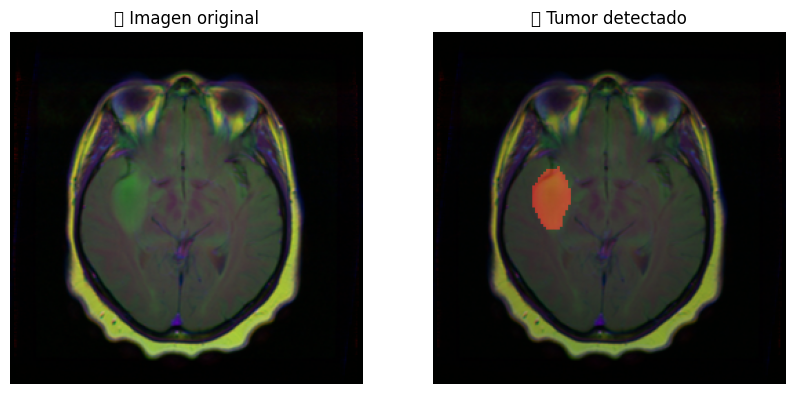

In [ ]:
original, overlay = predict_image(model, Image.open("TCGA_CS_4942_19970222_9.tif"))

# Mostrar resultado
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("🧠 Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("🔍 Tumor detectado")
plt.axis("off")

plt.show()

<ipython-input-27-9ff4bbb68ad8>:27: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-27-9ff4bbb68ad8>:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-27-9ff4bbb68ad8>:27: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


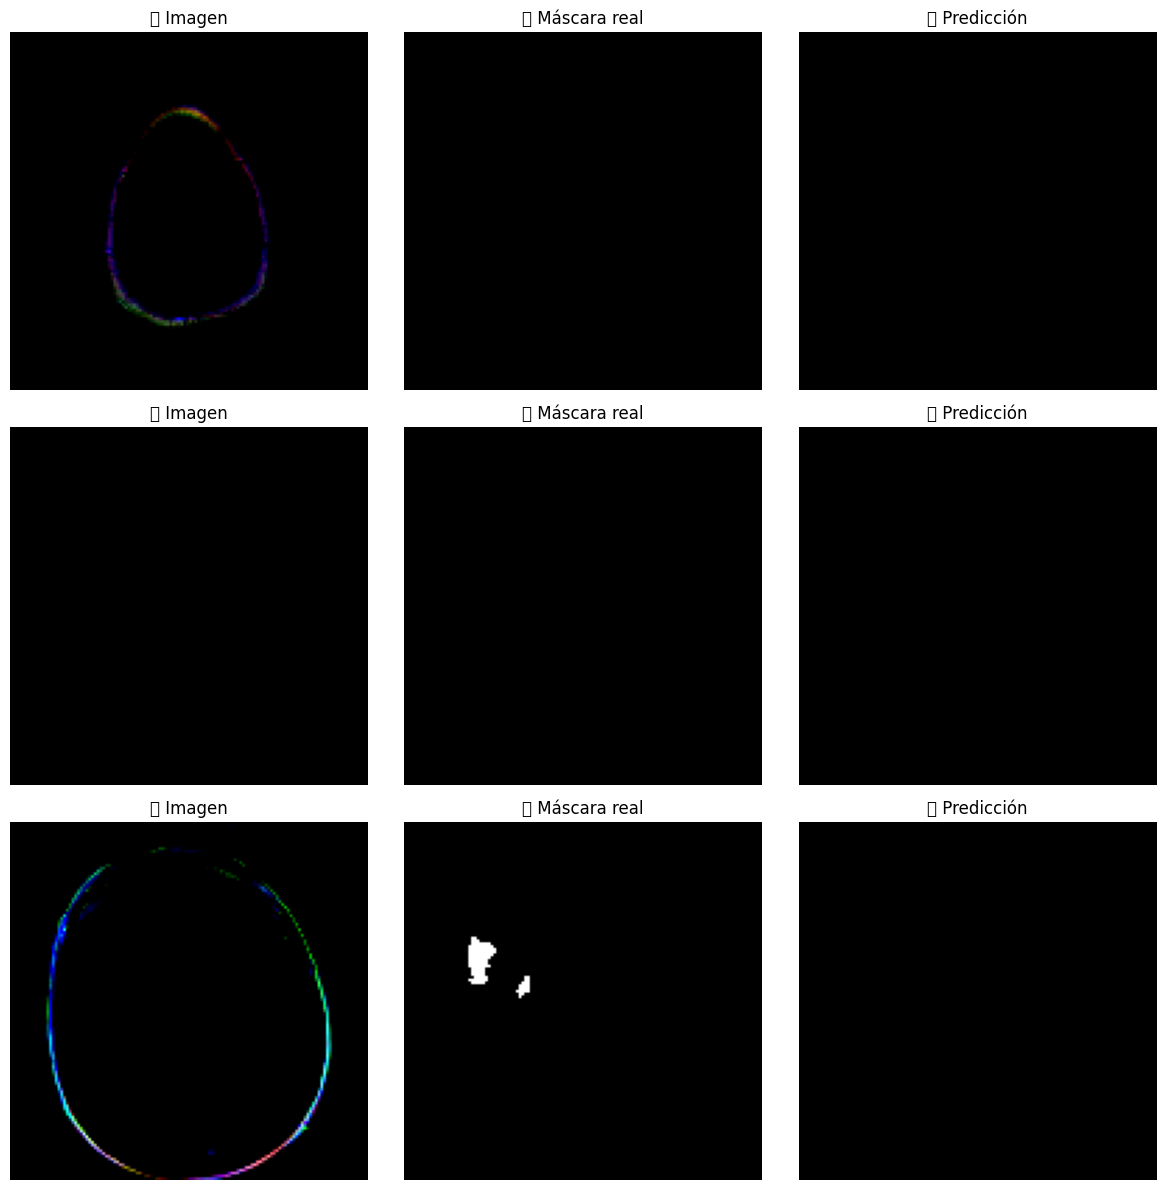

In [ ]:
#Paso 10: visualización de las predicciones
import random

def show_predictions(model, dataset, num=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num)
    fig, axs = plt.subplots(num, 3, figsize=(12, 4 * num))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        with torch.no_grad():
            pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))
            pred = (pred > 0.5).float().cpu().squeeze()

        axs[i, 0].imshow(img.permute(1, 2, 0).cpu())
        axs[i, 0].set_title('🧠 Imagen')

        axs[i, 1].imshow(mask.squeeze().cpu(), cmap='gray')
        axs[i, 1].set_title('✅ Máscara real')

        axs[i, 2].imshow(pred, cmap='gray')
        axs[i, 2].set_title('🔮 Predicción')

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar predicciones con el modelo entrenado
show_predictions(model, val_dataset)